In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
# necessary libaries
import steamdata
import preprocess
import pandas as pd
import database
import preprocess
from nltk import word_tokenize

In [3]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

#### **1) DATA ACQUISITION**

In [ ]:
# Gets top 100 -> DO NOT RUN

app_ids = steamdata.get_app_ids() # -> Retrieves best 100 of top sellers weekly chart.
steamdata.update_data() # -> Sends an API Call for each game, parses the response and saves in DB

total expected reviews to download: 120000


#### **2) PRE-PROCESSING**

In [4]:
# Gets data from database
df = database.get_data_from_database()
# Preprocess review
df = preprocess.preProcessData(df)
# Save in database clean review in additional column
# database.send_to_database(df)

#### **3) EDA**

In [5]:
df = database.get_data_from_database()
df["original_review"] = df["review"]
df["review"] = [word_tokenize(string) for string in df["review"]]
df["review_clean"] = [word_tokenize(string) for string in df["review_clean"]]

Wordclous for reviews of first 4 games:

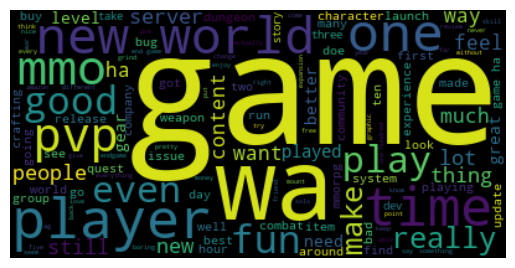

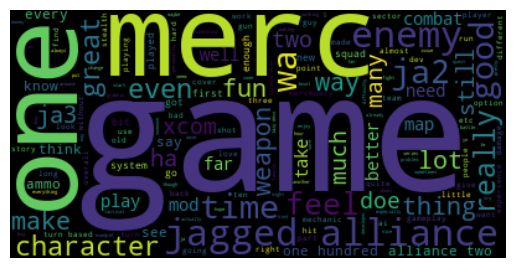

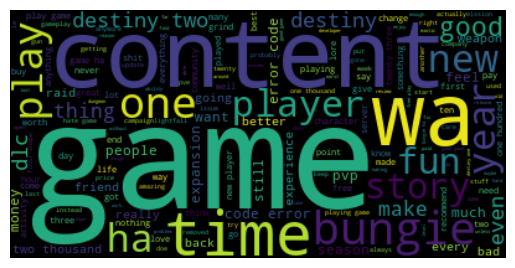

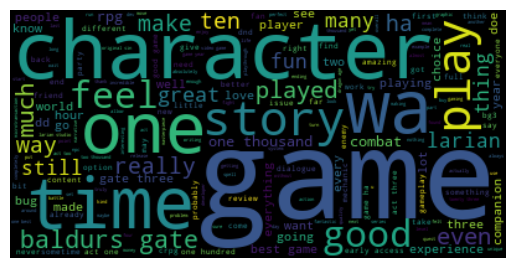

In [6]:
import visualizations
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

reviews_per_game = (df.groupby("app_id")
                    .apply(lambda row: [review for review in row["review_clean"]])
                    .tolist())

num_games_to_visualize = 4

for i, reviews in enumerate(reviews_per_game[:num_games_to_visualize]):
    # join tokens of each review
    reviews_texts = [' '.join(review) for review in reviews]
    # join reviews
    all_reviews_for_game = ' '.join(reviews_texts)
    visualizations.visualize_wordcloud(all_reviews_for_game, False)

Wordcloud for reviews of all games:

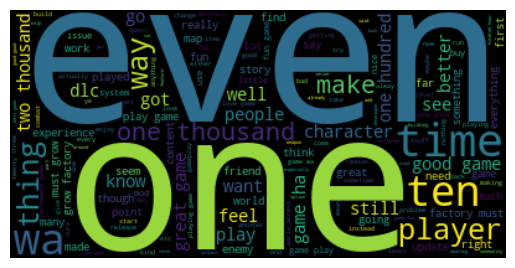

In [7]:
# first try 
# but something seems wrong as word count histogram shows different results
# TODO: solve mistake
all_reviews_for_all_games = ' '.join([' '.join(review) for review in df['review_clean']])
visualizations.visualize_wordcloud(all_reviews_for_all_games, False)

Histogram for reviews of first 4 games:

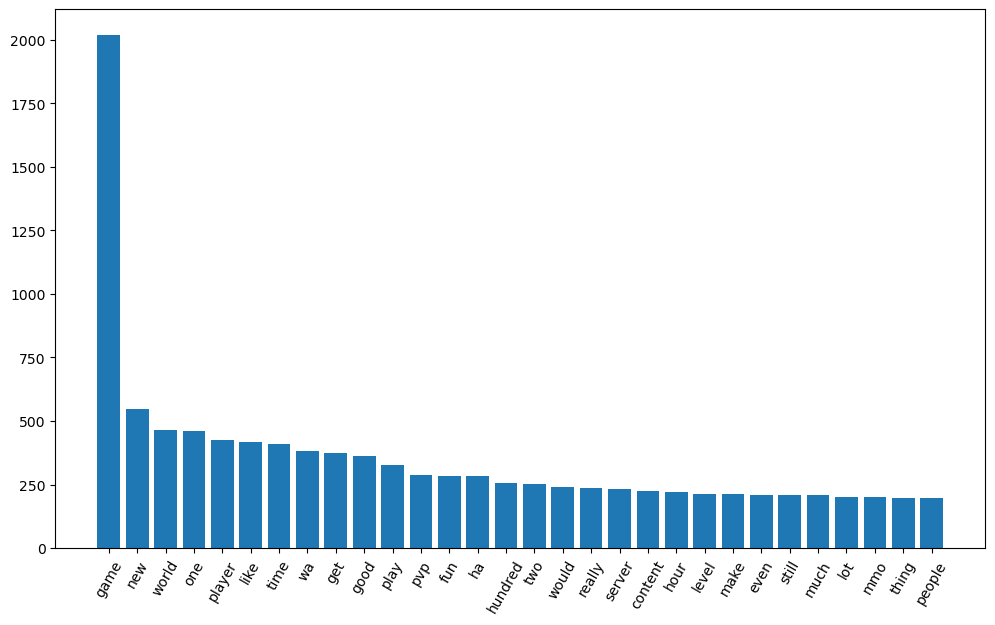

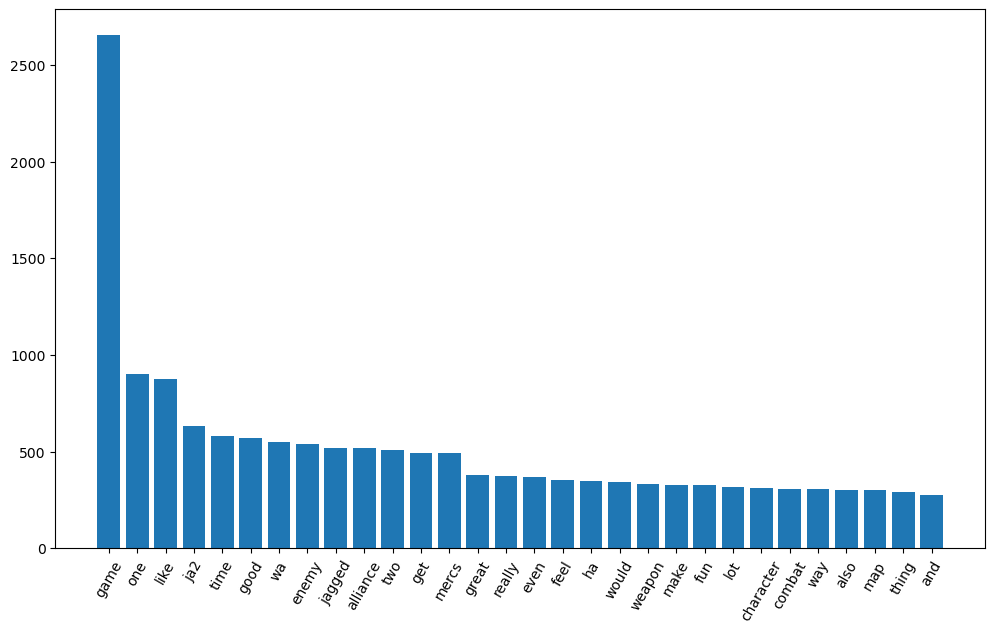

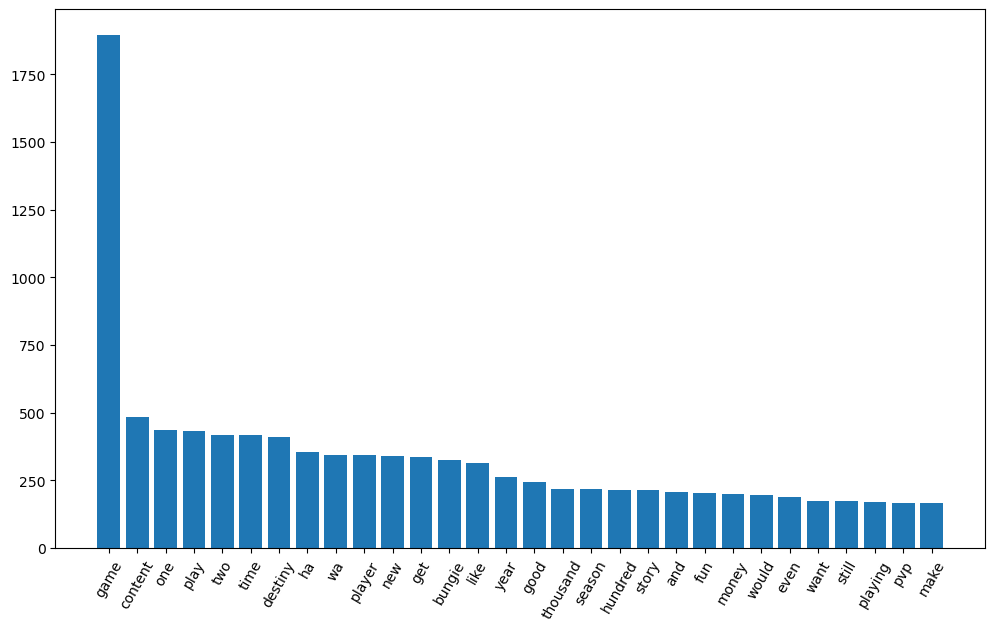

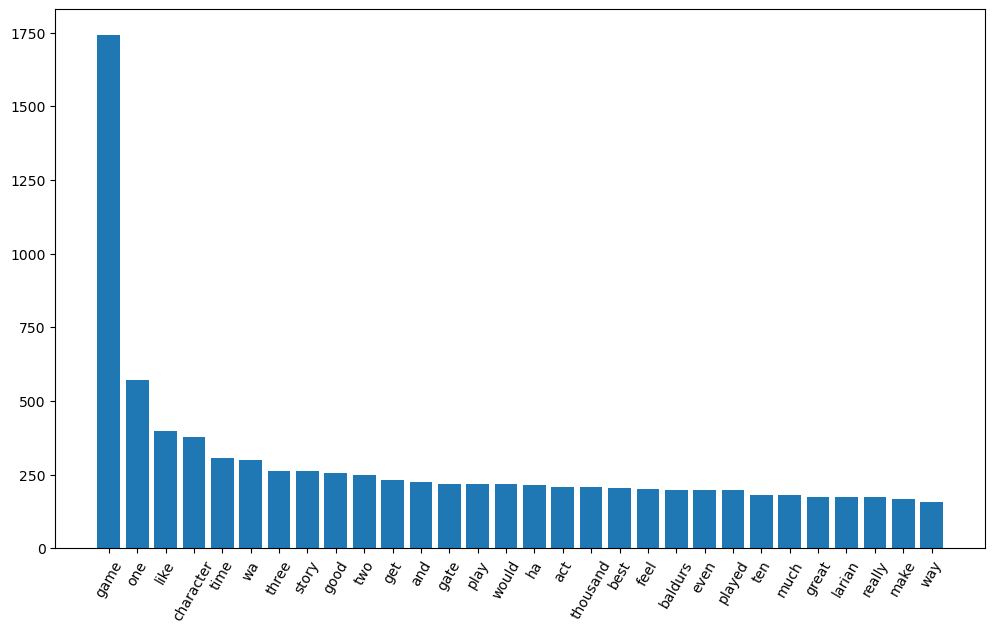

In [8]:
for i, reviews in enumerate(reviews_per_game[:num_games_to_visualize]):
    tokens_concatenated = [token for review in reviews for token in review]
    # requires list of words
    visualizations.visualize_word_count(tokens_concatenated)

Historgam for reviews of all games:

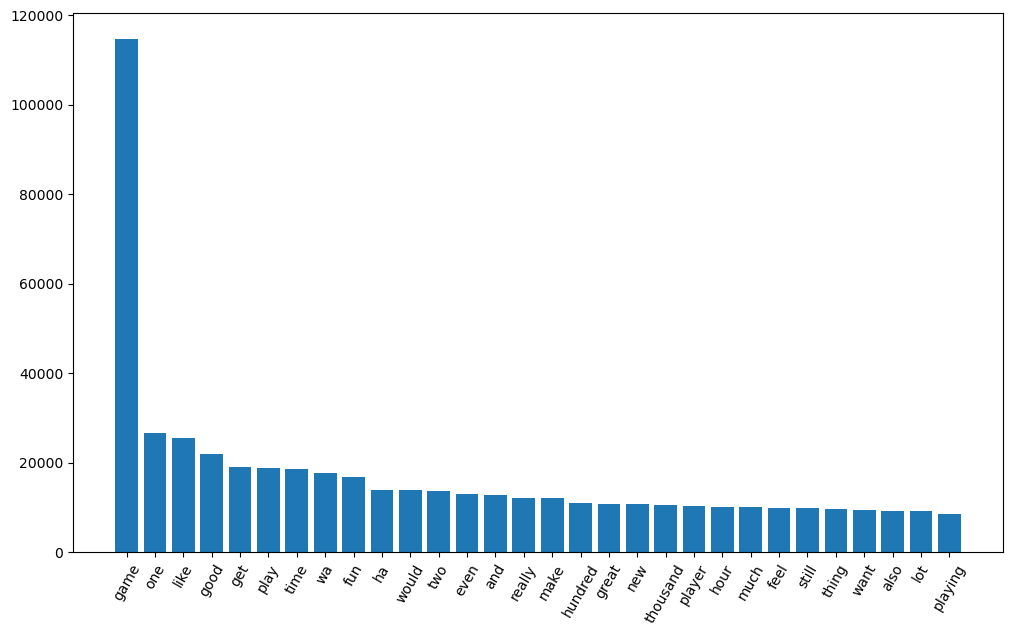

In [9]:
from itertools import chain

all_reviews_for_all_games = list(chain.from_iterable([review for reviews in reviews_per_game for review in reviews]))
visualizations.visualize_word_count(all_reviews_for_all_games)

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U20'), dtype('<U20')) -> None

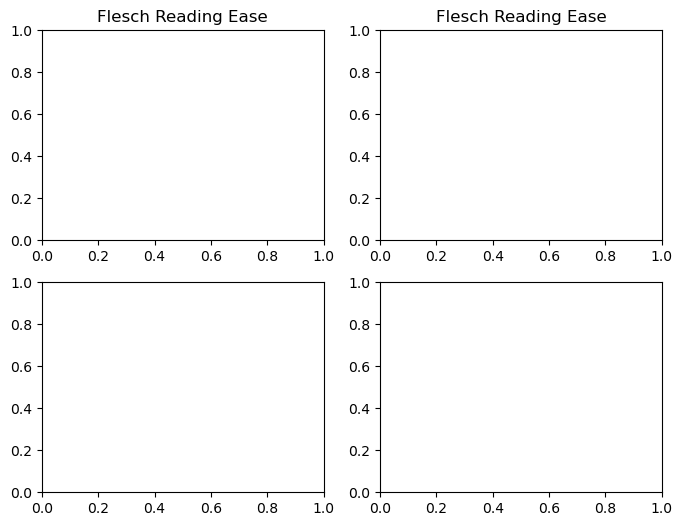

In [10]:
reviews_untokenized_per_game = (df.groupby("app_id")
                                .apply(lambda row: [review for review in row["review"]])
                                .tolist())
game_ids = (df.groupby("app_id")
            .apply(lambda row: row["app_id"])
            .unique()
            .tolist())

for reviews_untokenized, game_id in zip(reviews_untokenized_per_game, game_ids):
    visualizations.readability_scores(reviews_untokenized, "GameID: " + str(game_id))

### Words per Review Distribution

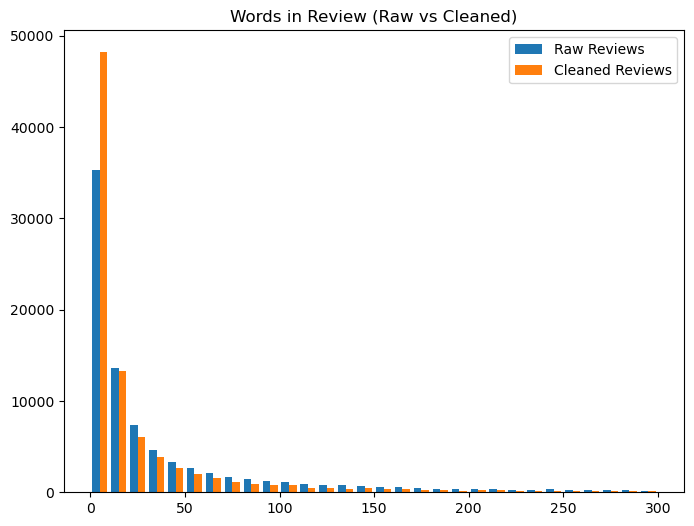

In [11]:
import visualizations
from importlib import reload

reload(visualizations)

df["#words"] = df["review"].apply(lambda word_tokens: len(word_tokens))
df["#words_clean"] = df["review_clean"].apply(lambda word_tokens: len(word_tokens))

max_words = 300

visualizations.plot_word_count_histogram([df[df["#words"] <= max_words]["#words"], df[df["#words_clean"] <= max_words]["#words_clean"]], 
                              ["Raw Reviews", "Cleaned Reviews"])

In [ ]:
import textstat

df["flesch_reading_ease"] = df["original_review"].apply(lambda review: textstat.flesch_reading_ease(review))
df["automated_readability_index"] = df["original_review"].apply(lambda review: textstat.automated_readability_index(review))

In [ ]:
flesch_reading_ease = df[(df["flesch_reading_ease"] > 0) & (df["flesch_reading_ease"] < 200)]["flesch_reading_ease"]
automated_readability_index = df[(df["automated_readability_index"] > 0) & (df["automated_readability_index"] < 20)]["automated_readability_index"]

visualizations.readability_scores(flesch_reading_ease, automated_readability_index, "Total Readability")